<center><img src="https://i.imgur.com/YNtjmbq.png" width="800"></center> 




# Lab 5 - Modelos de redes


Hay diferentes modelos de redes, y conocerlos es muy adecuado para el caso de la innovación. Veamos:

In [1]:
#librerias necesarias
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

Creemos funcion de resumen básico:

In [2]:
def analyze_graph_properties_with_judgment(G, graph_name="Grafo", verbose=True):
    """
    Acepta un grafo NetworkX y genera un resumen de sus propiedades clave,
    incluyendo un juicio cualitativo sobre su idoneidad para la difusión de innovación.
    Si el grafo no está conectado, analiza el diámetro del GCC.
    
    La función retorna el diccionario de métricas calculadas.
    Solo imprime el análisis detallado y los juicios cualitativos si 'verbose' es True.
    Las métricas en formato de diccionario NUNCA se imprimen en la consola, solo se retornan.

    Args:
        G (networkx.Graph): El grafo NetworkX a analizar.
        graph_name (str): Un nombre opcional para el grafo, usado en la salida.
        verbose (bool): Si es True, imprime el análisis detallado y los juicios.

    Returns:
        dict: Un diccionario con las métricas clave:
              'nodes', 'edges', 'num_components', 'largest_cc_size', 'ccg_percentage',
              'diameter_gcc', 'avg_clustering', 'max_degree', 'avg_degree', 'degree_distribution_type'
    """
    metrics = {}
    
    num_nodes = G.number_of_nodes()
    metrics['nodes'] = num_nodes
    metrics['edges'] = G.number_of_edges()

    if verbose:
        print(f"\n--- Análisis de Propiedades para: {graph_name} ---")
        print(f"  Nodos: {num_nodes}, Aristas: {G.number_of_edges()}")

    num_components = nx.number_connected_components(G)
    metrics['num_components'] = num_components

    largest_cc_size = 0
    largest_cc_graph = None 
    
    if num_nodes > 0:
        components = list(nx.connected_components(G))
        largest_cc_nodes = max(components, key=len)
        largest_cc_size = len(largest_cc_nodes)
        largest_cc_graph = G.subgraph(largest_cc_nodes)
    
    metrics['largest_cc_size'] = largest_cc_size
    
    ccg_percentage = (largest_cc_size / num_nodes) * 100 if num_nodes > 0 else 0
    metrics['ccg_percentage'] = ccg_percentage

    if verbose:
        print(f"  Componentes Conectados: {num_components}")
        print(f"  Tamaño del Mayor Componente Conectado (Giant Component - GCC): {largest_cc_size}")
        if num_components == 1 and num_nodes > 0:
            print("    Juicio: ¡Excelente conectividad! La red es un solo componente gigante, ideal para la difusión en toda la red.")
        elif ccg_percentage >= 80:
            print(f"    Juicio: Muy buena conectividad. El GCC abarca el {ccg_percentage:.1f}% de la red, lo que permite una amplia difusión dentro de él.")
        elif ccg_percentage >= 50:
            print(f"    Juicio: Conectividad aceptable. El GCC cubre el {ccg_percentage:.1f}% de la red, pero hay cierta fragmentación que aísla nodos.")
        else:
            print(f"    Juicio: Conectividad deficiente. El GCC es pequeño ({ccg_percentage:.1f}%), la red está altamente fragmentada, lo que limita severamente la difusión global.")

    diameter = 'N/A'
    diameter_judgment = 'N/A (no aplicable o no conectado)'
    
    if largest_cc_size > 1:
        try:
            diameter = nx.diameter(largest_cc_graph)
            metrics['diameter_gcc'] = diameter
            if verbose:
                print(f"  Diámetro del GCC (o de toda la red si está conectada): {diameter}")
            
            avg_k_gcc = (2 * largest_cc_graph.number_of_edges()) / largest_cc_size if largest_cc_size > 0 else 0
            if avg_k_gcc > 1:
                expected_er_diameter_approx = np.log(largest_cc_size) / np.log(avg_k_gcc)
            else:
                expected_er_diameter_approx = np.inf
            metrics['expected_er_diameter_approx'] = expected_er_diameter_approx


            log_n_gcc = np.log2(largest_cc_size) if largest_cc_size > 1 else 0
            
            if diameter <= (log_n_gcc * 1.5) or diameter <= 7:
                diameter_judgment = "¡Excelente! Diámetro muy corto DENTRO del GCC, la innovación puede llegar rápidamente a cualquier punto en el componente principal."
            elif diameter <= (log_n_gcc * 3) or diameter <= 15:
                diameter_judgment = "Bueno. Diámetro razonablemente corto DENTRO del GCC, permite una buena velocidad de difusión en el componente principal."
            else:
                diameter_judgment = "Deficiente. Diámetro largo DENTRO del GCC, la difusión de la innovación será lenta incluso en el componente principal."
        except nx.NetworkXError:
            if verbose:
                print(f"  Diámetro: N/A (el GCC tiene solo 1 nodo o no se pudo calcular el diámetro).")
            metrics['diameter_gcc'] = np.nan
            diameter_judgment = "N/A (el GCC tiene solo 1 nodo o no se pudo calcular el diámetro)."
    else:
        if verbose:
            print(f"  Diámetro: N/A (el GCC tiene 1 nodo o el grafo está vacío).")
        metrics['diameter_gcc'] = np.nan
        diameter_judgment = "N/A (el GCC tiene 1 nodo o el grafo está vacío)."

    if verbose:
        print(f"    Juicio: {diameter_judgment}")

    avg_clustering = nx.average_clustering(G)
    metrics['avg_clustering'] = avg_clustering
    if verbose:
        print(f"  Clustering Coeficiente Promedio: {avg_clustering:.3f}")

        if avg_clustering > 0.35:
            print("    Juicio: ¡Excelente! Alto clustering, lo que fomenta la confianza y validación local de la innovación.")
        elif avg_clustering > 0.15:
            print("    Juicio: Bueno. Clustering moderado, hay cierta cohesión local para la validación.")
        else:
            print("    Juicio: Deficiente. Bajo clustering, la validación y confianza local para la innovación pueden ser difíciles.")

    degrees = [d for n, d in G.degree()]
    metrics['max_degree'] = 0
    metrics['avg_degree'] = 0.0
    metrics['degree_distribution_type'] = "Más Uniforme" 

    if num_nodes > 0:
        max_degree = max(degrees)
        avg_degree = np.mean(degrees)
        metrics['max_degree'] = max_degree
        metrics['avg_degree'] = avg_degree

        if len(degrees) > 1:
            degree_variance = np.var(degrees)
            if avg_degree > 0 and degree_variance / avg_degree > 1.5:
                metrics['degree_distribution_type'] = "Cola Larga (Potencialmente Hubs)"
            else:
                metrics['degree_distribution_type'] = "Más Uniforme"
            
        if verbose:
            print(f"  Grado Máximo: {max_degree}, Grado Promedio: {avg_degree:.2f}")

        if metrics['degree_distribution_type'] == "Cola Larga (Potencialmente Hubs)":
             if verbose:
                print("    Juicio: ¡Excelente! Clara presencia de 'hubs' (nodos de alto grado) indicados por una distribución de grado asimétrica, ideales para una difusión rápida y amplia si se activan.")
        else:
            if verbose:
                print("    Juicio: Más Uniforme. Poca o ninguna presencia de 'hubs' prominentes; la difusión dependerá más de la densidad general o de la propiedad de mundo pequeño.")
    else:
        if verbose:
            print("  No hay nodos para analizar grados.")

    if verbose:
        print("--------------------------------------------------")
    
    return metrics

Asumamos, para todos los casos, que trabajaremos con 50 agentes, que en promedio ellos tendrán 4 contactos.

In [3]:
num_nodes = 100
avg_degree = 4

### 1. Red Aleatoria (Erdos-Renyi): La más simple, donde los enlaces se forman al azar.

Para crear una de estas, necesitamos estos parámetros:

* n: número de nodos
* p: probabilidad de conexión entre cualquier par de nodos. p se calcula a partir del grado promedio deseado: p = avg_degree / (n - 1)

Con esos parámetros, asi se crea una red E-R:

In [4]:
p_er = avg_degree / (num_nodes - 1)
G_er = nx.erdos_renyi_graph(num_nodes, p_er, seed=42) # seed para reproducibilidad

In [5]:
analyze_graph_properties_with_judgment(G_er, "Red Aleatoria (Erdos-Renyi)")


--- Análisis de Propiedades para: Red Aleatoria (Erdos-Renyi) ---
  Nodos: 100, Aristas: 177
  Componentes Conectados: 4
  Tamaño del Mayor Componente Conectado (Giant Component - GCC): 97
    Juicio: Muy buena conectividad. El GCC abarca el 97.0% de la red, lo que permite una amplia difusión dentro de él.
  Diámetro del GCC (o de toda la red si está conectada): 7
    Juicio: ¡Excelente! Diámetro muy corto DENTRO del GCC, la innovación puede llegar rápidamente a cualquier punto en el componente principal.
  Clustering Coeficiente Promedio: 0.019
    Juicio: Deficiente. Bajo clustering, la validación y confianza local para la innovación pueden ser difíciles.
  Grado Máximo: 9, Grado Promedio: 3.54
    Juicio: Más Uniforme. Poca o ninguna presencia de 'hubs' prominentes; la difusión dependerá más de la densidad general o de la propiedad de mundo pequeño.
--------------------------------------------------


{'nodes': 100,
 'edges': 177,
 'num_components': 4,
 'largest_cc_size': 97,
 'ccg_percentage': 97.0,
 'diameter_gcc': 7,
 'expected_er_diameter_approx': 3.5337252291478642,
 'avg_clustering': 0.018500000000000003,
 'max_degree': 9,
 'avg_degree': 3.54,
 'degree_distribution_type': 'Más Uniforme'}

### 2. Red de Mundo Pequeño (Watts-Strogatz)

* n: número de nodos
* k: grado inicial de cada nodo (usemos 'numero par')
* p: probabilidad de reconexión de aristas

In [6]:
k_ws = avg_degree
p_ws = 0.2 
G_ws = nx.watts_strogatz_graph(num_nodes, k_ws, p_ws, seed=42)

In [7]:
analyze_graph_properties_with_judgment(G_ws, "Red de Mundo Pequeño (Watts-Strogatz)")


--- Análisis de Propiedades para: Red de Mundo Pequeño (Watts-Strogatz) ---
  Nodos: 100, Aristas: 200
  Componentes Conectados: 1
  Tamaño del Mayor Componente Conectado (Giant Component - GCC): 100
    Juicio: ¡Excelente conectividad! La red es un solo componente gigante, ideal para la difusión en toda la red.
  Diámetro del GCC (o de toda la red si está conectada): 8
    Juicio: ¡Excelente! Diámetro muy corto DENTRO del GCC, la innovación puede llegar rápidamente a cualquier punto en el componente principal.
  Clustering Coeficiente Promedio: 0.259
    Juicio: Bueno. Clustering moderado, hay cierta cohesión local para la validación.
  Grado Máximo: 6, Grado Promedio: 4.00
    Juicio: Más Uniforme. Poca o ninguna presencia de 'hubs' prominentes; la difusión dependerá más de la densidad general o de la propiedad de mundo pequeño.
--------------------------------------------------


{'nodes': 100,
 'edges': 200,
 'num_components': 1,
 'largest_cc_size': 100,
 'ccg_percentage': 100.0,
 'diameter_gcc': 8,
 'expected_er_diameter_approx': 3.3219280948873626,
 'avg_clustering': 0.259,
 'max_degree': 6,
 'avg_degree': 4.0,
 'degree_distribution_type': 'Más Uniforme'}

### 3. Red Libre de Escala (Barabási-Albert)

* n: número de nodos
* m: número de aristas que añade cada nuevo nodo. Se busca que el grado promedio sea aproximadamente 2*m


In [8]:
m_ba = int(avg_degree / 2) if avg_degree >= 2 else 1
G_ba = nx.barabasi_albert_graph(num_nodes, m_ba, seed=42)

In [9]:
analyze_graph_properties_with_judgment(G_ba, "Red Libre de Escala (Barabási-Albert)")


--- Análisis de Propiedades para: Red Libre de Escala (Barabási-Albert) ---
  Nodos: 100, Aristas: 196
  Componentes Conectados: 1
  Tamaño del Mayor Componente Conectado (Giant Component - GCC): 100
    Juicio: ¡Excelente conectividad! La red es un solo componente gigante, ideal para la difusión en toda la red.
  Diámetro del GCC (o de toda la red si está conectada): 5
    Juicio: ¡Excelente! Diámetro muy corto DENTRO del GCC, la innovación puede llegar rápidamente a cualquier punto en el componente principal.
  Clustering Coeficiente Promedio: 0.163
    Juicio: Bueno. Clustering moderado, hay cierta cohesión local para la validación.
  Grado Máximo: 36, Grado Promedio: 3.92
    Juicio: ¡Excelente! Clara presencia de 'hubs' (nodos de alto grado) indicados por una distribución de grado asimétrica, ideales para una difusión rápida y amplia si se activan.
--------------------------------------------------


{'nodes': 100,
 'edges': 196,
 'num_components': 1,
 'largest_cc_size': 100,
 'ccg_percentage': 100.0,
 'diameter_gcc': 5,
 'expected_er_diameter_approx': 3.3710550629381926,
 'avg_clustering': 0.16338786067733438,
 'max_degree': 36,
 'avg_degree': 3.92,
 'degree_distribution_type': 'Cola Larga (Potencialmente Hubs)'}

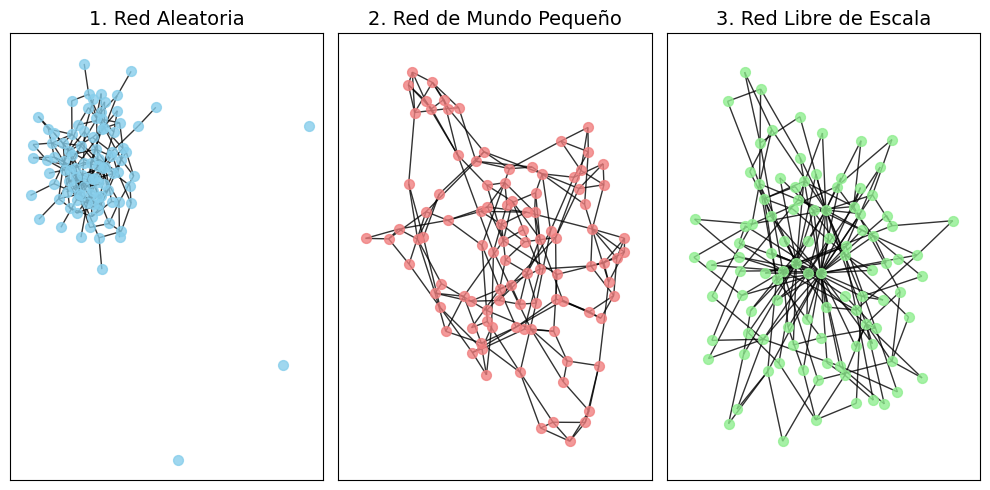

In [10]:
# --- Visualización de los Grafos ---
fig, axes = plt.subplots(1, 3, figsize=(10, 5)) # 2 filas, 2 columnas para 4 grafos

# Red Aleatoria
ax1 = axes[0]
pos_er = nx.spring_layout(G_er, seed=42)
nx.draw_networkx(G_er, pos_er, with_labels=False, node_size=50, node_color='skyblue', ax=ax1, alpha=0.8)
ax1.set_title("1. Red Aleatoria", size=14)

# Red de Mundo Pequeño
ax2 = axes[1]
pos_ws = nx.spring_layout(G_ws, seed=42)
nx.draw_networkx(G_ws, pos_ws, with_labels=False, node_size=50, node_color='lightcoral', ax=ax2, alpha=0.8)
ax2.set_title("2. Red de Mundo Pequeño", size=14)

# Red Libre de Escala
ax3 = axes[2]
pos_ba = nx.spring_layout(G_ba, seed=42)
nx.draw_networkx(G_ba, pos_ba, with_labels=False, node_size=50, node_color='lightgreen', ax=ax3, alpha=0.8)
ax3.set_title("3. Red Libre de Escala", size=14)


for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

Imagina ahora que en tu trabajo de campo has recolectado esta red:

In [11]:
# --- 1. Crear el Grafo ---
# Un grafo no dirigido, perfecto para redes de interacción como la innovación.
innovation_network = nx.Graph()

# --- 2. Definir Nodos y sus Roles ---
# Cada línea añade un nodo al grafo. Puedes cambiar el nombre del nodo (ej. 'Inventor1')
# y el texto del 'role' para que tus alumnos lo personalicen.

# Grupo de Inventores (I)
innovation_network.add_node('I_Ana', role='Inventor')
innovation_network.add_node('I_Ben', role='Inventor')
innovation_network.add_node('I_Carla', role='Inventor')
innovation_network.add_node('I_Dan', role='Inventor')
innovation_network.add_node('I_Eva', role='Inventor')

# Grupo de Emprendedores (E)
innovation_network.add_node('E_Fran', role='Emprendedor')
innovation_network.add_node('E_Gus', role='Emprendedor')
innovation_network.add_node('E_Hana', role='Emprendedor')
innovation_network.add_node('E_Ivan', role='Emprendedor')

# Grupo de Consultores (C) - C_Julia será nuestro "super-conector"
innovation_network.add_node('C_Julia', role='Consultor')
innovation_network.add_node('C_Ken', role='Consultor')
innovation_network.add_node('C_Lia', role='Consultor')

# Grupo de Financistas (F)
innovation_network.add_node('F_Max', role='Financista')
innovation_network.add_node('F_Nora', role='Financista')

# Grupo de Administradores (A)
innovation_network.add_node('A_Omar', role='Administrador')
innovation_network.add_node('A_Pau', role='Administrador')
innovation_network.add_node('A_Quim', role='Administrador')

# Grupo de Usuarios (U)
innovation_network.add_node('U_Rosa', role='Usuario')
innovation_network.add_node('U_Sam', role='Usuario')
innovation_network.add_node('U_Teo', role='Usuario')


# --- 3. Definir Aristas (Conexiones entre Nodos) ---
# Las interacciones, aquí radica toda la diferencia!
# Cada tupla (nodo_A, nodo_B) representa una conexión.
# Pueden añadir o quitar líneas, o cambiar los nombres de los nodos.

# Conexiones Intra-Rol (dentro del mismo tipo de actor, alta confianza)
# Inventores colaboran entre sí (?)
innovation_network.add_edge('I_Ana', 'I_Ben')
innovation_network.add_edge('I_Ben', 'I_Carla')
innovation_network.add_edge('I_Carla', 'I_Dan')
innovation_network.add_edge('I_Dan', 'I_Eva')
innovation_network.add_edge('I_Eva', 'I_Ana') 

# Emprendedores comparten experiencias (?)
innovation_network.add_edge('E_Fran', 'E_Gus')
innovation_network.add_edge('E_Gus', 'E_Hana')
innovation_network.add_edge('E_Hana', 'E_Ivan')

# Financistas se conocen (?)
innovation_network.add_edge('F_Max', 'F_Nora')

# Administradores coordinan (?)
innovation_network.add_edge('A_Omar', 'A_Pau')

# Usuarios interactúan (grupo de prueba de un producto)
innovation_network.add_edge('U_Rosa', 'U_Sam')
innovation_network.add_edge('U_Sam', 'U_Teo')


# Conexiones Inter-Rol (entre diferentes tipos de actores, flujos de innovación)
# Inventores a Emprendedores (ideas a desarrollo)
innovation_network.add_edge('I_Ana', 'E_Fran')
innovation_network.add_edge('I_Ben', 'E_Gus')
innovation_network.add_edge('I_Carla', 'E_Hana')
innovation_network.add_edge('I_Dan', 'E_Ivan')

# Emprendedores a Financistas (búsqueda de capital)
innovation_network.add_edge('E_Fran', 'F_Max')
innovation_network.add_edge('E_Hana', 'F_Nora')

# Emprendedores a Usuarios (feedback, adopción)
innovation_network.add_edge('E_Fran', 'U_Rosa')
innovation_network.add_edge('E_Gus', 'U_Sam')
innovation_network.add_edge('E_Ivan', 'U_Teo')

# Consultor C_Julia: Nuestro "Hub" principal (conecta a muchos roles)
innovation_network.add_edge('C_Julia', 'I_Ana')
innovation_network.add_edge('C_Julia', 'E_Fran')
innovation_network.add_edge('C_Julia', 'F_Max')
innovation_network.add_edge('C_Julia', 'A_Omar')
innovation_network.add_edge('C_Julia', 'U_Rosa')
innovation_network.add_edge('C_Julia', 'C_Ken') # Conecta con otro consultor

# Otros Consultores (C_Ken, C_Lia)
innovation_network.add_edge('C_Ken', 'I_Ben')
innovation_network.add_edge('C_Ken', 'E_Gus')
innovation_network.add_edge('C_Lia', 'I_Dan')
innovation_network.add_edge('C_Lia', 'F_Nora')
innovation_network.add_edge('C_Lia', 'A_Pau')

# Administradores (facilitadores)
innovation_network.add_edge('A_Omar', 'E_Gus')
innovation_network.add_edge('A_Omar', 'F_Max')
innovation_network.add_edge('A_Pau', 'I_Carla')
innovation_network.add_edge('A_Pau', 'E_Hana')
innovation_network.add_edge('A_Quim', 'I_Eva')
innovation_network.add_edge('A_Quim', 'U_Teo')

Red creada con 20 nodos y 38 aristas.


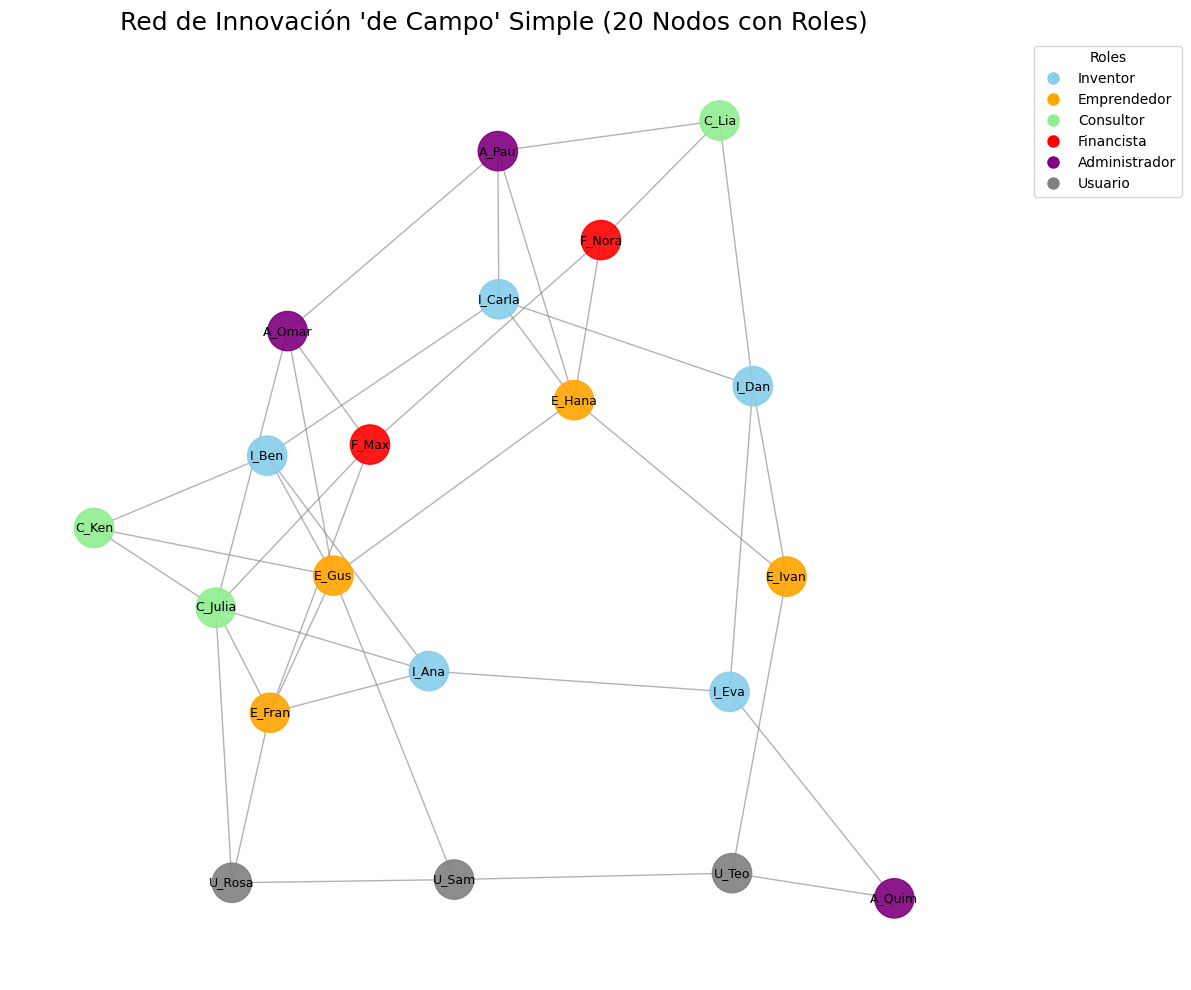

In [12]:
# --- 4. Preparación para Visualización y Análisis ---
print(f"Red creada con {innovation_network.number_of_nodes()} nodos y {innovation_network.number_of_edges()} aristas.")

# Asignar colores basados en roles para la visualización
node_colors = {
    'Inventor': 'skyblue',
    'Emprendedor': 'orange',
    'Consultor': 'lightgreen',
    'Financista': 'red',
    'Administrador': 'purple',
    'Usuario': 'gray'
}

# Crear una lista de colores de nodos en el mismo orden que los nodos del grafo
colors = [node_colors[innovation_network.nodes[node]['role']] for node in innovation_network.nodes()]

# Configurar las etiquetas de los nodos (mostrar el nombre del nodo)
labels = {node: node for node in innovation_network.nodes()}

# --- 5. Visualizar la Red (Opcional, pero muy recomendado) ---
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(innovation_network, seed=50) # Layout para visualizar (seed para reproducibilidad)

nx.draw_networkx_nodes(innovation_network, pos, node_color=colors, node_size=800, alpha=0.9)
nx.draw_networkx_edges(innovation_network, pos, edge_color='gray', alpha=0.6)
nx.draw_networkx_labels(innovation_network, pos, labels, font_size=9, font_color='black')

# Añadir leyenda de roles (para entender los colores)
legend_handles = []
for role, color in node_colors.items():
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=role,
                                      markerfacecolor=color, markersize=10))
plt.legend(handles=legend_handles, title="Roles", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Red de Innovación 'de Campo' Simple (20 Nodos con Roles)", size=18)
plt.axis('off')
plt.tight_layout() # Ajusta el layout para que la leyenda no se solape
plt.show()

In [13]:
def compare_to_theoretical_models(metrics, graph_name="Grafo Analizado", verbose=True):
    """
    Compara las métricas de un grafo con las características típicas de modelos de redes teóricos
    (Erdos-Renyi, Watts-Strogatz, Barabási-Albert) para inferir a cuál se parece más.

    Args:
        metrics (dict): Diccionario de métricas obtenido de analyze_graph_properties_with_judgment.
        graph_name (str): Nombre del grafo para fines de impresión.
        verbose (bool): Si es True, imprime la comparación detallada.

    Returns:
        str: El tipo de modelo teórico al que más se acerca el grafo.
    """
    if verbose:
        print(f"\n--- Comparación con Modelos Teóricos para: {graph_name} ---")
    
    num_nodes = metrics.get('nodes', 0)
    avg_clustering = metrics.get('avg_clustering', 0)
    diameter_gcc = metrics.get('diameter_gcc', np.nan)
    degree_dist_type = metrics.get('degree_distribution_type', 'Desconocido')
    largest_cc_size = metrics.get('largest_cc_size', 0)
    
    model_match = []

    # --- 1. Criterio de Mundo Pequeño (Small-World / Watts-Strogatz) ---
    is_small_world_match = False 
    if largest_cc_size > 1 and not np.isnan(diameter_gcc):
        expected_er_diameter = metrics.get('expected_er_diameter_approx', np.inf)

        if avg_clustering > 0.25 and diameter_gcc <= (expected_er_diameter * 1.5):
            model_match.append("Mundo Pequeño (Watts-Strogatz)")
            is_small_world_match = True
            if verbose:
                print(f"  - **Coincidencia:** Se asemeja a una Red de Mundo Pequeño (Watts-Strogatz). Alto clustering ({avg_clustering:.3f}) y diámetro corto ({diameter_gcc}) comparable a un grafo aleatorio.")
        elif verbose:
            print(f"  - **No Coincidencia (Mundo Pequeño):** Clustering ({avg_clustering:.3f}) o diámetro ({diameter_gcc}) no cumplen los criterios. (Se requiere C > 0.25 y D ~ D_ER)")
    else: 
        if avg_clustering > 0.25:
            if verbose:
                print(f"  - **Coincidencia Parcial (Mundo Pequeño):** Posiblemente Mundo Pequeño (Watts-Strogatz) basado en clustering alto ({avg_clustering:.3f}), pero el diámetro no se pudo determinar completamente (GCC muy pequeño o desconectado).")
        elif verbose:
            print(f"  - **No Coincidencia (Mundo Pequeño):** Poco probable que sea Mundo Pequeño (Watts-Strogatz) debido a bajo clustering ({avg_clustering:.3f}).")


    # --- 2. Criterio de Libre de Escala (Barabási-Albert) ---
    if "Cola Larga" in degree_dist_type:
        model_match.append("Libre de Escala (Barabási-Albert)")
        if verbose:
            print(f"  - **Coincidencia:** Se asemeja a una Red Libre de Escala (Barabási-Albert). Presenta una distribución de grado con 'cola larga' (tipo: {degree_dist_type}).")
    elif verbose:
        print(f"  - **No Coincidencia (Libre de Escala):** La distribución de grado es más uniforme (tipo: {degree_dist_type}).")

    # --- 3. Criterio de Aleatoria (Erdos-Renyi) ---
    if not is_small_world_match and "Más Uniforme" in degree_dist_type:
        if avg_clustering < 0.15:
            model_match.append("Aleatoria (Erdos-Renyi)")
            if verbose:
                print(f"  - **Coincidencia:** Se asemeja a una Red Aleatoria (Erdos-Renyi). Bajo clustering ({avg_clustering:.3f}) y distribución de grado más uniforme.")
        elif verbose:
            print(f"  - **No Coincidencia (Erdos-Renyi):** Aunque tiene distribución de grado uniforme, su clustering ({avg_clustering:.3f}) es más alto de lo esperado para ER puro (se requiere < 0.15).")
    elif verbose:
        print(f"  - **No Coincidencia (Erdos-Renyi):** No cumple los criterios principales (es Mundo Pequeño O la distribución de grado no es uniforme).")

    # --- Veredicto Final basado en coincidencias ---
    if len(model_match) == 0:
        final_judgment = "Las propiedades de la red no se alinean claramente con ninguno de los modelos teóricos puros (posiblemente un modelo híbrido o atípico)."
    elif len(model_match) == 1:
        final_judgment = f"La red se acerca más al modelo: {model_match[0]}."
    else:
        final_judgment = f"La red exhibe características de múltiples modelos: {', '.join(model_match)}. Esto es común en redes reales (híbrida)."

    if verbose:
        print(f"\n--- Conclusión General para '{graph_name}' ---")
        print(final_judgment)
        print("--------------------------------------------------")
    
    return final_judgment

In [14]:
# --- 4. Analizar las Propiedades de la Red ---
# verbose=True para ver el análisis detallado y juicios
network_metrics = analyze_graph_properties_with_judgment(
    innovation_network,
    "Mi Red de Innovación (Trabajo de Campo)",
    verbose=True 
)

# --- 5. Comparar con Modelos Teóricos ---
# verbose=True para ver la comparación detallada
model_type_classification = compare_to_theoretical_models(
    network_metrics,
    "Mi Red de Innovación (Trabajo de Campo)",
    verbose=True 
)

print(f"\nClasificación final del modelo: La red se clasifica como: {model_type_classification}")


--- Análisis de Propiedades para: Mi Red de Innovación (Trabajo de Campo) ---
  Nodos: 20, Aristas: 38
  Componentes Conectados: 1
  Tamaño del Mayor Componente Conectado (Giant Component - GCC): 20
    Juicio: ¡Excelente conectividad! La red es un solo componente gigante, ideal para la difusión en toda la red.
  Diámetro del GCC (o de toda la red si está conectada): 4
    Juicio: ¡Excelente! Diámetro muy corto DENTRO del GCC, la innovación puede llegar rápidamente a cualquier punto en el componente principal.
  Clustering Coeficiente Promedio: 0.128
    Juicio: Deficiente. Bajo clustering, la validación y confianza local para la innovación pueden ser difíciles.
  Grado Máximo: 6, Grado Promedio: 3.80
    Juicio: Más Uniforme. Poca o ninguna presencia de 'hubs' prominentes; la difusión dependerá más de la densidad general o de la propiedad de mundo pequeño.
--------------------------------------------------

--- Comparación con Modelos Teóricos para: Mi Red de Innovación (Trabajo de C